In [343]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.linalg import cho_factor, cho_solve, LinAlgError
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import json
import math

import requests 
from scipy.optimize import minimize, Bounds, LinearConstraint
from typing import Union, Sequence, Tuple

In [344]:
url = "https://giris.epias.com.tr"
 
headertgt = {"Content-Type" : "application/x-www-form-urlencoded",
             "Accept" : "text/plain"}
 
paramtgt = {"username" : "******",
            "password" : "******"}

In [345]:
date1 = "2025-01-01T00:00:00+03:00"
date2 = "2025-10-30T00:00:00+03:00"    #sontarihin tamamını alıyor
#date3 = "2025-01-31T00:00:00+03:00"   #Üretim için kullanılıyor

base_path    = "https://seffaflik.epias.com.tr/electricity-service"
TGT_response = requests.post(url+"/cas/v1/tickets", headers = headertgt, data = paramtgt)

header={"Content-Type" : "application/json",
        "Accept" : "application/json",
        "Accept-Language" :"en",
        "TGT" : TGT_response.text}

In [346]:
params = json.dumps({"startDate": date1, "endDate": date2,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
result  = requests.request("POST", base_path+"/v1/markets/dam/data/mcp",  data = params, headers=header)

In [347]:
df = pd.DataFrame(result.json()['items'])
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_datetime(df['hour']).dt.hour

df["res1"] = df["price"]/df["priceUsd"]*df["priceUsd"].mean()
df["ges1"] = df["price"]/df["priceEur"]*df["priceEur"].mean()
df['tes1'] = df['hour'].apply(lambda x: 2000  if x >=12  else 3000 )
df['des1'] = df["price"] *0.98

df["res"] = df["res1"]/df["res1"].max() * 3
df["ges"] = df["ges1"]/df["ges1"].max() * (df["ges1"] / df["res1"])
df["tes"] = df["tes1"]/df["tes1"].max() * (df["tes1"] / df["res1"])
df["des"] = df["des1"]/df["des1"].max() * (df["des1"] / df["res1"])

norm = (df["price"]/df["des1"].max()).mean()

C:\Users\gulis\AppData\Local\Temp\ipykernel_25804\792204823.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['hour']).dt.hour


10 aylık veri çekildi. Saatlik elektrik fiyatı elde edildikten sonra USD, TRY ve EUR biriminde datalar türetildi. Veri aralığı içinde

- USD/MWh olan değerler, serinin maksimumuna bölündü. Bu sayede 0-1 arasında veri elde edildi.
- EUR/MWh olan değerler, EUR/USD ile çarpılarak artırıldı.
- TRY/MWh iki fiyatlı ikili anlaşma oluşturuldu.
- TRY/MWh olan değerler, TRY/USD ile çarpılarak artırıldı.

Veriyi küçültüldü ve oranlarla aralarındaki büyüklük korundu. 

In [348]:
df[['res','tes','des','ges']].describe()

,res,tes,des,ges
count,7230.000000,7230.000000,7.230000e+03,7230.000000
mean,2.156600,0.847331,8.172833e-01,0.813778
std,0.117231,0.329640,3.664444e-01,0.112919
min,1.851852,0.399543,1.788328e-08,0.610095
25%,2.029875,0.517103,5.683368e-01,0.716546
50%,2.167806,0.989939,9.069236e-01,0.833158
75%,2.261690,1.163441,1.104860e+00,0.916544
max,3.000000,1.361942,1.332330e+00,1.252463


In [349]:
#params1 = json.dumps({"startDate": date1, "endDate": date3, "powerPlantId" :"" ,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
#result2  = requests.request("POST", base_path+"/v1/generation/data/realtime-generation",  data = params1, headers=header)
#df2 = pd.DataFrame(result2.json()['items'])
#df2 = df2[["dammedHydro","naturalGas","wind","river"]]   #üretim için 


In [350]:
def optimalPortfolio(df: pd.DataFrame, C: float, gamma: float) -> Tuple[pd.Series, float, float]:
    """
    Interior mean–variance optimizer for procurement weights λ under:
        min_{λ}  C μ^T λ + γ C^2 λ^T Σ λ   s.t.  1^T λ = 1

    Parameters
    ----------
    df : pd.DataFrame
        Historical unit prices (not returns): rows = time, columns = instruments.
        NaNs are dropped row-wise before estimation.
    C : float
        Deterministic total energy requirement (> 0).
    gamma : float
        Risk aversion parameter on variance term (> 0).

    Returns
    -------
    np.ndarray
        The interior optimal weight vector λ* (length = number of columns in df).

    Notes
    -----
    - This returns the *interior* solution, which requires Σ ≻ 0 (SPD).
      If Σ is singular (e.g. a riskless/constant-price instrument or perfect collinearity),
      a ValueError is raised. In that case, remove/merge collinear sources or solve
      the full KKT system with inequality constraints as appropriate.
    - Uses a Cholesky factorization; no explicit matrix inverses are formed.
    """

    #Girdilerden kaynaklı anlamsız hataları verir
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame of historical unit prices.")
    if C <= 0:
        raise ValueError("C must be strictly positive.")
    if gamma <= 0:
        raise ValueError("gamma must be strictly positive.")


    # Nan varsa düşürür ve cov için en az iki satıra ihtiyaç var. 
    df_clean = df.dropna(how="any").astype(float)
    if df_clean.shape[0] < 2 or df_clean.shape[1] < 1:
        raise ValueError("Not enough data after dropping NaNs to estimate μ and Σ.")
    

    mu = df_clean.mean(axis=0).to_numpy()                 # E[p] 
    Sigma = df_clean.cov().to_numpy()                     # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T)                       # Symmetrize to dampen numerical asymmetry
    n = Sigma.shape[0]                                    # cov boyutu bulundu
    ones = np.ones(n)                                     # Birim vektör (cov boyutunda)

    # Cholesky-based solves to avoid explicit inversion ----- Bu blok, Σ’nın sağlıklı olduğunu garanti altına alıyor
    try:
        cF = cho_factor(Sigma, lower=True, check_finite=True)
    except LinAlgError as e:
        raise ValueError("Covariance matrix Σ is not SPD; interior solution undefined.") from e

    # Solve Σ x = 1 and Σ y = μ
    Sigma_inv_1 = cho_solve(cF, ones)                    #Σ^{−1} * 1
    Sigma_inv_mu = cho_solve(cF, mu)                     #Σ^{−1} * μ

    denom = float(ones @ Sigma_inv_1)                    # 1^T * Σ^{-1} * 1
    if denom <= 0 or not np.isfinite(denom):
        raise ValueError("Numerical issue: 1^T Σ^{-1} 1 must be positive and finite.")

    eta_num = 2.0 * gamma * (C**2) + C * float(ones @ Sigma_inv_mu)    # 2γC^{2} + C1^{⊤}Σ^{−1}μ
    eta = eta_num / denom                                              # [ 2γC^{2} + C1^{⊤}Σ^{−1}μ ] / [ 1^T * Σ^{-1} * 1] 

    # λ* = (1/(2 γ C^2)) [ Σ^{-1}(η 1 - C μ) ] = (1/(2 γ C^2)) (η Σ^{-1}1 - C Σ^{-1}μ)
    lam = (eta * Sigma_inv_1 - C * Sigma_inv_mu) / (2.0 * gamma * (C**2))
    # lam = (C * Sigma_inv_mu - eta * Sigma_inv_1) / (2.0 * gamma * (C**2))

    
    # Optional: enforce the affine constraint numerically (tiny adjustment)
    lam += (1.0 - lam.sum()) * (Sigma_inv_1 / denom)                   # 1^{⊤} * λ = 1 kısıtını mikro ayarla geri oturtur düzeltme amaçlıdır.

    w = pd.DataFrame(lam, index= ['res','tes','des','ges'] )
    E = C * float(mu @ lam)
    V = (C**2) * float(lam @ Sigma @ lam)
    
    return w, E, V 

In [351]:
def optimalPortfoliononshort(
    df: pd.DataFrame,
    C: float,
    gamma: float,
    lower_bounds: Union[float, Sequence[float]] = 0.0,
    upper_bounds: Union[float, Sequence[float]] = 1.0,
    ridge: float = 1e-8,
) -> Tuple[pd.Series, float, float]:
    """
    Solve:  min_λ  C μ^T λ + γ C^2 λ^T Σ λ
            s.t.   1^T λ = 1,  lb ≤ λ ≤ ub
    df: price levels (rows=time, cols=sources). Returns (λ*, E[X], Var[X]).
    """
    if C <= 0 or gamma <= 0:
        raise ValueError("C and gamma must be > 0.")                              # risk katsayısı ve C >0 olmalı
    X = df.dropna(axis=1, how="all").dropna(axis=0, how="any").astype(float)      # Nan lar atılır
    if X.shape[0] < 2 or X.shape[1] < 1:
        raise ValueError("Not enough data.")                                      # Cov için boyutu minumum 2x2 olmalıdır

    mu = X.mean().to_numpy()                                                      # E[p]
    Sigma = X.cov(ddof=1).to_numpy()                                              # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T) + ridge * np.eye(len(mu))                     # Symmetrize to dampen numerical asymmetry
    n = len(mu)                                                                   # mu boyutu bulundu

    # expand bounds to vectors
    lb = np.full(n, lower_bounds if np.isscalar(lower_bounds) else np.asarray(lower_bounds, float))  #lower bound
    ub = np.full(n, upper_bounds if np.isscalar(upper_bounds) else np.asarray(upper_bounds, float))  #Upper bound
    if lb.sum() > 1 + 1e-12 or ub.sum() < 1 - 1e-12:
        raise ValueError("Infeasible bounds: need sum(lb) ≤ 1 ≤ sum(ub).")                           #sum(lb) ≤ 1 ≤ sum(ub) şartını manuel test ediyor

    # feasible start: begin at lb, spread remaining mass toward ub
    w0 = lb.copy()                                         # ilk olarak ağırlıklar minimuma eşitleniyor
    rem = 1.0 - w0.sum()                                   # Eşitlik koşulundan yola çıkarak 1'den çıkarılıyor
    if rem > 0:                                            # Ağırlıklar bulunur
        room = np.maximum(ub - w0, 0.0)
        total = room.sum()
        if total > 0: w0 += rem * (room / total)           # toplamın 1 e eşit olduğu sağlanır
    w0 = np.clip(w0, lb, ub)                               # ağırlıkları (w) sınırlar içinde burakır

    def fun(w):  return C * mu @ w + gamma * (C**2) * (w @ Sigma @ w)  #fonksiyon f(w)=Cμ⊤w+γC2w⊤Σw amaç fonk  scaler
    def jac(w):  return C * mu + 2.0 * gamma * (C**2) * (Sigma @ w)    #jacobien  ∇f(w)=Cμ+2γC2Σw   1. Türev   (n,)
    def hess(w): return 2.0 * gamma * (C**2) * Sigma                   #hessian   ∇2f(w)=2γC2Σ      2. Türev   (n,n)

    cons = [LinearConstraint(np.ones((1, n)), 1.0, 1.0)]                # w vektörü ve sınırlar toplamlar 1 e eşit
    bnds = Bounds(lb, ub)                                               # Sınırlar 
    opt  = minimize(fun, w0, method="trust-constr", jac=jac, hess=hess, # Optimizasyon tam olarak burda yapılır ve newton tabanlıdır.
                   bounds=bnds, constraints=cons,
                   options={"maxiter": 500, "gtol": 1e-10, "xtol": 1e-12, "verbose": 0})  
    #gtol=1e-10	Gradyan normu bu değerden küçükse dur.
    #xtol=1e-12	w vektöründeki değişim bu değerden küçükse dur.
    #maxiter=500	Maksimum iterasyon sayısı.
    #verbose=0	Çıktı susturulmuş. 2 yapsan her adımı loglar.
    
    if not opt.success:
        raise RuntimeError(f"Optimization failed: {opt.message}")  # algoritmanın neden durduğunu açıklayan yazı "opt.***" gibi türev bilgi verilebilir.

    w = pd.Series(opt.x, index=X.columns, name="λ*")
    E = C * float(mu @ opt.x)
    V = (C**2) * float(opt.x.T @ Sigma @ opt.x)
    return w, E, V

C ve gamma'nın sıfırdan büyük olması şarttır. İki fonksiyonda da (sort ve nonshort) bu kısıtlar mevcuttur. 

- C > 0 olmak zorundadır. Talebin sıfır ve daha küçük olması anlamsızdır.
- gamma > 0 olmak zorundadır.
  * gamma riskten kaçınma katsayısıdır.
  * gamma = 0 olursa E[R] minimize olur.
  * gamma < 0 olursa risk sever bir durum olmakla birlikte varyansı maksimize etmeye iter ve problem ekonomik olarak anlamsızlaşabilir. 
  

In [352]:
prices = df[['res','tes','des','ges']].dropna()
#prices = df2.dropna()
C=10000
gamma= 1.00  #risk katsayısı
n = prices.shape[1]                                    # cov boyutu bulundu
upper_bounds = np.ones(n)   

w, E, V = optimalPortfoliononshort(prices, C=C, gamma=gamma,  upper_bounds=upper_bounds)
print("non sort position")
print(w.round(6))
print(f"Expected cost: {E:,.2f}  |  Variance: {V:,.2f}")

print("with sort position")
w1, E1, V1 =  optimalPortfolio(prices,C,gamma)
print(w1.round(6))
print(f"Expected cost: {E1:,.2f}  |  Variance: {V1:,.2f}")

rf = E * 1.08                              # % 8 faizle bunu yapmaya çalışsın. 
print(f"Referans Fiyat: {rf:,.2f}")

non sort position
res    0.017045
tes    0.136921
des    0.045760
ges    0.800274
Name: λ*, dtype: float64
Expected cost: 8,414.21  |  Variance: 1,004,611.03
with sort position
            0
res  0.017038
tes  0.136921
des  0.045760
ges  0.800281
Expected cost: 8,414.11  |  Variance: 1,004,610.46
Referans Fiyat: 9,087.34


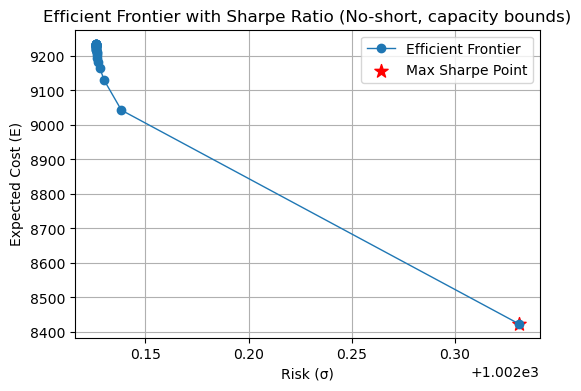

🔹 Best Sharpe Ratio = -8.4041
   γ = 1.0000
   Expected Cost (E) = 8,423.70
   Risk (σ) = 1,002.33
   Normalde TL  = 7,701.16


In [353]:
gammas = np.linspace(1, 90 , 30)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfoliononshort(prices, C=C, gamma=g,
                                       lower_bounds=0.0, upper_bounds=upper_bounds, ridge=1e-6)  
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = -E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]  #Hocanın istediği tanjantın eğimi


plt.figure(figsize=(6,4))
plt.plot(S_list, E_list, marker='o', linewidth=1, label="Efficient Frontier")
plt.scatter(best_sigma, best_E, color='red', s = 100, marker='*', label='Max Sharpe Point')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.title("Efficient Frontier with Sharpe Ratio (No-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(axis='y' , style='plain', useOffset=False)
plt.ticklabel_format(axis='x' , style='sci', useOffset=True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.4f}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {norm* C:,.2f}")

nonshort = pd.DataFrame({'E ns': E_list, 'Sigma ns': S_list, 'Sharpe ns': Sharpe_list ,'gamma ns': gammas  })

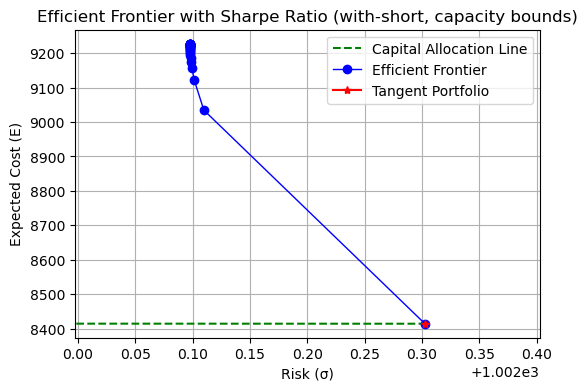

🔹 Best Sharpe Ratio = -8.3948
   γ = 1.0e+00
   Expected Cost (E) = 8,414.11
   Risk (σ) = 1,002.30
   Normalde TL  = 7,701.16


In [354]:
gammas = np.linspace(1, 90 , 30)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfolio(prices, C=C, gamma=g )
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = -E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]

#rf = norm * C
#sigma_line = np.linspace(1, max(S_list)*1.1, 10)
#E_line = rf + best_sharpe * sigma_line

plt.figure(figsize=(6,4))

# Capital Allocation Line (rf'den tanjant noktaya)
xline = np.linspace(0, max(S_list), 30)
yline = rf + (best_E - rf) / np.array(S_list) * xline
plt.plot(xline, yline, ls='--', color='green' , label="Capital Allocation Line")
plt.xlim([min(S_list)*0.9999, max(S_list)*1.0001])
plt.plot(S_list, E_list, marker='o',  color='blue' , linewidth=1, label="Efficient Frontier")
plt.plot(best_sigma, best_E, color='red',  marker='*', label='Tangent Portfolio')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.ticklabel_format(style='plain', axis='both')
plt.title("Efficient Frontier with Sharpe Ratio (with-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(axis='y' , style='plain', useOffset=False)
plt.ticklabel_format(axis='x' , style='sci', useOffset=True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.1e}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {rf:,.2f}")

withshort = pd.DataFrame({'E ws': E_list, 'Sigma ws': S_list, 'Sharpe ws': Sharpe_list ,'gamma ws': gammas  })

Türetilen veriler yani elektrik fiyatı verileri, bir birinden türetilen veriler olduğu için genellikle seçilen portföyde 1 seçeneğe çok yüksek lamda çıkıyor. Buda varyansı düşük olan seçenektir. Gamma radikal değişse bile E ve Sigma neredeyse mikro boyutta değişmektedir. Bu sebeple verilerle oynanmış ve dolar bazlı olan sütun bir çarpanla çarpılmıştır. 

In [356]:
#------------------------------
#Birinci Türevın Max olduğu nokta bulundu. Sharpe ile aynı olduğu teyir edildi. 
#------------------------------
data = pd.concat([withshort,nonshort], axis=1  )
interview = np.linspace(1, 30 , 30)

derivative_list = []
for i in range(len(interview)-1):
    derivative = (data["E ws"][i+1] - data["E ws"][i]) / (data["Sigma ws"][i+1] - data["Sigma ws"][i])
    derivative_list.append(derivative)
idx_max = np.argmin(derivative_list) +1 


-----------------------------------------------------------------------------------------------
Sharpe Oranı tanjant alfayı vermektedir. En iyi sharpe oranı en yüksek olanıdır. Çünkü risk başına beklenen gelir daha yüksek olacaktır. 

* E = Rf + S ⋅ σ

E  portföyün beklenen getirisi
Rf risksiz getiri (saatlik fiyat * C = norm)
σ portföyün riski
S Sharpe oranı (tanjantın eğimi)

* S = (E - RF) / σ

Monte Carlo Simulation 

In [381]:
mu    = prices.mean().to_numpy()                                                      # E[p]
Sigma = prices.cov(ddof=1).to_numpy()      
C = C
λ = w1 #non -short
λ = w  #with short 

# 10.000 senaryo simülasyonu
n_sim = 10_000
p = np.random.multivariate_normal(mu, Sigma, n_sim)   # ortalama maliyet üretildi. Rastgele ama mantıklı. 


# Toplam maliyet
X = C * p @ λ

# İstatistikler


mean_cost = X.values.mean()
std_dev   = X.values.var() **0.5
print(f"Beklenen Maliyet: {mean_cost:.2f}, Varyans: {std_dev:.2f}")


Beklenen Maliyet: 9215.90, Varyans: 1010.74


In [377]:
mean_cost

np.float64(9228.096027049962)